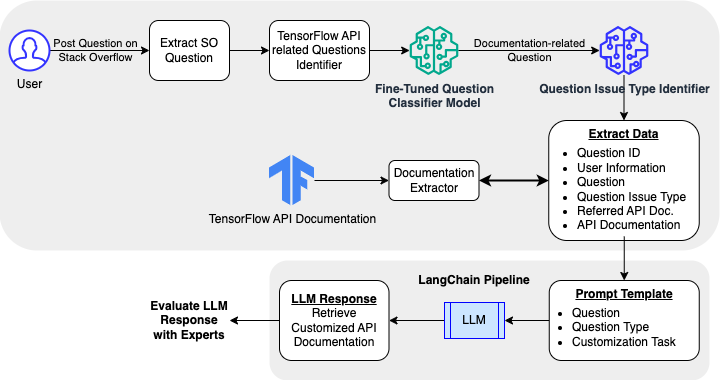

### **Questions Issue Types**

1. **Documentation Replication on Other Examples**

  - Issues related to replicating the documentation examples on other different examples.
  - **Prompt Task:** `Provide examples replicating the documentation on other examples along with explanation with respect to the question asked by the user.`

2. **Documentation Ambiguity**

  - Issues related to not understanding the content properly.
  - **Prompt Task:** `Provide step by step explanations and examples to understand the content of the documentation with respect to the question asked by the user.`

3. **Documentation Completeness**

  - Issues that mention that the documentation is incomplete or missing information.
  - **Prompt Task:** `Complete the documentation by adding the information with respect to the question asked by the user.`

4. **Documentation Replicability**

  - Issues related to replicating the documentation examples
  - **Prompt Task:** `Provide complete examples replicating the examples provided within the documentation with respect to the question asked by the user.`

5. **Inadequate Examples**

  - Issues that mention the documentation has insufficient examples.
  - **Prompt Task:** `Provide multiple complete examples to showcase its usability with respect to the question asked by the user.`

6. **Lack of Alternative Solutions**

  - Issues that mention the unavailability of alternative solutions or documentation.
  - **Prompt Task:** `Provide alternative solutions with respect to the question asked by the user.`

7. **Requesting (Additional) Documentation/ Examples**

  - Questions that request additional examples or documentations as a support.
  - **Prompt Task:** `Provide links to reliable additional documentation or examples with respect to the question asked by the user.`

### Potention GPT Models Information
Prices are per 1,000 tokens, where 1,000 tokens is about 750 words. (**`GPT-4 Turbo` is a preview version**)


| GPT Model   | Context Window  | Training Data   | Input          | Output    |
| --------    | --------        | --------        | --------       | --------  |
| GPT-4 Turbo | 128,000 Tokens  | Up to Apr 2023  | \$0.01/1K tokens | \$0.03/1K tokens|
| GPT-4 8K    |   8,192 Tokens  | Up to Sep 2021  | \$0.03/1K tokens | \$0.06/1K tokens|
| GPT-4 32K   |  32,768 Tokens  | Up to Sep 2021  | \$0.06/1K tokens | \$0.12/1K tokens|
| GPT-3.5     |  16,385 Tokens  | Up to Sep 2021  | \$0.0005/1K tokens | \$0.0020/1K tokens|


# Code

**Import Libraries**

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import os
import time
import json
import getpass
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

from setfit import SetFitModel

# LangChain packages
from langchain_openai import ChatOpenAI
from langchain.tools import Tool
from langchain.agents import load_tools
from langchain.agents import initialize_agent
from langchain.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document
from langchain.storage import InMemoryStore
from langchain.retrievers import ParentDocumentRetriever
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain.callbacks import MlflowCallbackHandler
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain import hub
from langchain.agents import create_openai_functions_agent
from langchain.agents import AgentExecutor
from langchain.document_loaders import DataFrameLoader, DirectoryLoader, YoutubeLoader, TextLoader

from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CohereRerank

# Setup environment with API keys
from dotenv import load_dotenv, find_dotenv
dotenv_path = find_dotenv()
load_dotenv(dotenv_path=dotenv_path)

# =================================================================
# Setup API keys
# =================================================================
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

GOOGLE_CSE_ID = os.getenv("GOOGLE_CSE_ID")
os.environ["GOOGLE_CSE_ID"] = GOOGLE_CSE_ID

TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY

COHERE_API_KEY = os.getenv("COHERE_API_KEY")
os.environ["COHERE_API_KEY"] = COHERE_API_KEY
# =================================================================


from langchain_openai import OpenAIEmbeddings
embedding_function = OpenAIEmbeddings(model="text-embedding-3-large")


# Include custom python modules
import lib.helper_funcs as hf
import lib.global_settings as s
import lib.api as api
import lib.utils as utils



In [2]:
import mlflow
mlflow.set_tracking_uri("databricks")
mlflow.set_experiment("/Users/sharukat@gmail.com/DocumentCustomizer")

<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/782057818488460', creation_time=1707424687928, experiment_id='782057818488460', last_update_time=1707927555086, lifecycle_stage='active', name='/Users/sharukat@gmail.com/DocumentCustomizer', tags={'mlflow.experiment.sourceName': '/Users/sharukat@gmail.com/DocumentCustomizer',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'sharukat@gmail.com',
 'mlflow.ownerId': '7145086246729944'}>

#### Classify Stack Overflow Questions (Documentation-related)

SQL query to extract questions based on the question IDs

```mysql
SELECT
    p.Id AS QuestionId,
    p.Title,
    p.Body,
    CONCAT('https://stackoverflow.com/questions/', p.Id) AS QuestionURL,
    p.OwnerUserId AS UserId
FROM Posts p
WHERE p.Id IN (your_list_of_question_ids_here);
```


In [3]:
tf_api_ques = pd.read_csv(os.path.join(s.DATA_PATH, "tf_api_questions_v1.csv"))
tf_api_ques['Body'] = tf_api_ques['Body'].apply(utils.text_preprocessor)
tf_api_ques

,QuestionId,Title,Body,QuestionURL,UserId
0,33617638,TensorFlow (Mac OS X): can't determine number ...,"There must be a simple setting for Mac OS X, t...",https://stackoverflow.com/questions/33617638,904032.0
1,33624048,Fail to run word embedding example in tensorfl...,I am trying to run the word embedding example ...,https://stackoverflow.com/questions/33624048,1230772.0
2,33633370,How to print the value of a Tensor object in T...,I have been using the introductory example of ...,https://stackoverflow.com/questions/33633370,4993513.0
3,33641922,conditional graph in tensorflow and for loop t...,First the broad questions: My actual use case ...,https://stackoverflow.com/questions/33641922,3688217.0
4,33648167,Why do we name variables in Tensorflow?,"In some of the places, I saw the syntax, where...",https://stackoverflow.com/questions/33648167,4165313.0
...,...,...,...,...,...
34542,76444585,Create Multivariate Normal Distribution with L...,recently I am dealing with state space model. ...,https://stackoverflow.com/questions/76444585,6657003.0
34543,76447111,where is the documentation of keras.engine.seq...,I got &lt;class 'keras.engine.sequential.Seque...,https://stackoverflow.com/questions/76447111,3646484.0
34544,76447508,How to retrain a model that was saved using th...,I am building a Neural Machine Translator for ...,https://stackoverflow.com/questions/76447508,16851318.0
34545,76447653,The output sequence is almost uniform at each ...,I'm using LSTM (python/tensorflow) to build a ...,https://stackoverflow.com/questions/76447653,11472474.0


In [4]:
doc_related = []
model = SetFitModel.from_pretrained("sharukat/so_mpnet-base_question_classifier")

#  Run inference
for index, row in tqdm(tf_api_ques.iterrows(), total=tf_api_ques.shape[0]):
    preds = model(row['Body'])
    doc_related.append(preds)
    

tf_api_ques['DocRelated'] = doc_related
tf_api_ques.head()


config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/164 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/22.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config_setfit.json:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

model_head.pkl:   0%|          | 0.00/7.01k [00:00<?, ?B/s]

100%|██████████| 34547/34547 [1:38:30<00:00,  5.85it/s]  


,QuestionId,Title,Body,QuestionURL,UserId,DocRelated
0,33617638,TensorFlow (Mac OS X): can't determine number ...,"There must be a simple setting for Mac OS X, t...",https://stackoverflow.com/questions/33617638,904032.0,0
1,33624048,Fail to run word embedding example in tensorfl...,I am trying to run the word embedding example ...,https://stackoverflow.com/questions/33624048,1230772.0,0
2,33633370,How to print the value of a Tensor object in T...,I have been using the introductory example of ...,https://stackoverflow.com/questions/33633370,4993513.0,0
3,33641922,conditional graph in tensorflow and for loop t...,First the broad questions: My actual use case ...,https://stackoverflow.com/questions/33641922,3688217.0,0
4,33648167,Why do we name variables in Tensorflow?,"In some of the places, I saw the syntax, where...",https://stackoverflow.com/questions/33648167,4165313.0,0


In [5]:
tf_api_ques.to_csv(os.path.join(s.DATA_PATH, "tf_api_questions_v2.csv"))
tf_doc_related_ques = tf_api_ques[tf_api_ques['DocRelated'] == 1]
tf_doc_related_ques.to_csv(os.path.join(s.DATA_PATH, "tf_doc_api_questions_v0.csv"), index=False)

tf_api_ques['DocRelated'].value_counts()

DocRelated
0    32542
1     2005
Name: count, dtype: int64

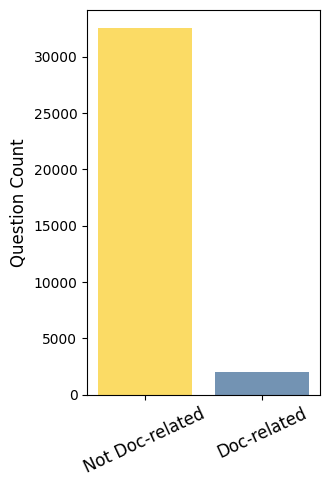

In [6]:
df = pd.read_csv(os.path.join(s.DATA_PATH, "tf_api_questions_v2.csv"))

class_counts = df["DocRelated"].value_counts()

# Extract data for plotting 
class_labels = ["Not Doc-related", "Doc-related"]
class_values = class_counts.to_numpy()


custom_colors = {
   "Not Doc-related": "#FBDB65",  # Example color for "Not Doc-related"
   "Doc-related": "#7393B3"   # Example color for "Doc-related"
}
plt.figure(figsize=(3, 5))  # Adjust figure size as needed
plt.bar(class_labels, class_values, color=[custom_colors[label] for label in class_labels])
plt.xticks(rotation=25, ha="center", fontsize=12,)  # Rotate x-axis labels for better readability
plt.ylabel("Question Count", fontdict={"fontsize":12})
# plt.title("Prevelance of TensorFlow API doc-related questions", fontdict={"fontsize":12, "fontweight":"bold"})
plt.savefig("./figures/doc-related_questions.pdf", format="pdf", bbox_inches="tight")
# Display the plot
plt.show()


In [7]:
tf_doc_related_ques

,QuestionId,Title,Body,QuestionURL,UserId,DocRelated
24,33720645,Why is this TensorFlow implementation vastly l...,As a toy example I'm trying to fit a function ...,https://stackoverflow.com/questions/33720645,1715157.0,1
26,33725159,Understanding Variable scope example in Tensor...,I was looking at the mechanics section for Ten...,https://stackoverflow.com/questions/33725159,5557105.0,1
28,33727935,How to use stop_gradient in Tensorflow,I'm wondering how to use stop_gradient in tens...,https://stackoverflow.com/questions/33727935,5565980.0,1
56,33932901,What's the purpose of tf.app.flags in TensorFlow?,"I am reading some example codes in Tensorflow,...",https://stackoverflow.com/questions/33932901,5607347.0,1
58,33943992,"In Tensorflow, how do I generate a scalar summ...",Does anyone have a minimal example of using a ...,https://stackoverflow.com/questions/33943992,5609344.0,1
...,...,...,...,...,...,...
34533,76433726,"reading and decoding a .tfrecord file, and sav...",I'm currently working on implementing a pytorc...,https://stackoverflow.com/questions/76433726,22042838.0,1
34535,76440119,Can't fold BatchNorm with Conv2D in Keras QAT ...,I'm currently trying to use Keras' Quantizatio...,https://stackoverflow.com/questions/76440119,21807405.0,1
34540,76444107,Are 'validation_steps' used if the validation_...,I was trying to use the Keras API to train a g...,https://stackoverflow.com/questions/76444107,11875606.0,1
34543,76447111,where is the documentation of keras.engine.seq...,I got &lt;class 'keras.engine.sequential.Seque...,https://stackoverflow.com/questions/76447111,3646484.0,1


In [8]:
doc_related_issue_types = pd.read_csv(os.path.join(s.DATA_PATH, "doc_related_annotated_issue_types_v0.csv"))
doc_related_issue_types = doc_related_issue_types[['QuestionId', 'Issue Type']]

common_data = pd.merge(tf_doc_related_ques, doc_related_issue_types, how='inner', on='QuestionId')
annotated_data = common_data[['QuestionId', 'Title', 'Body', 'DocRelated', 'Issue Type']]
annotated_data.to_csv(os.path.join(s.DATA_PATH, "annotated_data_v0.csv"))
annotated_data


,QuestionId,Title,Body,DocRelated,Issue Type
0,34589335,How does the distorted_inputs() function in th...,I was going through the CIFAR-10 example at Te...,1,Documentation Replication on Other Examples
1,34619177,What does tf.nn.conv2d do in tensorflow?,I was looking at the docs of tensorflow about ...,1,Documentation Replication on Other Examples
2,34642595,Tensorflow Strides Argument,I am trying to understand the strides argument...,1,Documentation Ambiguity
3,34931121,Can cond support TF ops with side effects?,The (source code) documentation for tf.cond is...,1,Documentation Replicability
4,35689547,How to process single training file in parallel,I have a file train.csv that contains paths to...,1,Documentation Replication on Other Examples
...,...,...,...,...,...
537,76380927,Tensorflow decode image,I am a beginner in tensorflow and I am trainin...,1,Requesting (Additional) Documentation/Examples
538,76391276,Custom gradient for broadcasting operation,I have an operation for which I want to define...,1,Documentation Ambiguity
539,76396532,"Ragged tensors in dataset, tensorflow, how do ...","I have in my model, for fitting, and my datase...",1,Documentation Replicability
540,76444107,Are 'validation_steps' used if the validation_...,I was trying to use the Keras API to train a g...,1,Documentation Replication on Other Examples


In [11]:
annotated_data['Issue Type'].value_counts()

Issue Type
Documentation Replication on Other Examples       198
Documentation Replicability                        94
Lack of Alternative Solutions/Documentation        86
Documentation Ambiguity                            82
Inadequate Examples                                43
Requesting (Additional) Documentation/Examples     24
Documentation Completeness                         15
Name: count, dtype: int64

In [9]:
# Doc-related issue type unannotated questions
ids_to_remove = annotated_data['QuestionId'].tolist()
df_filtered = tf_doc_related_ques.drop(tf_doc_related_ques[tf_doc_related_ques['QuestionId'].isin(ids_to_remove)].index)

# Since we already have 542 annotated ones, randomly select 1000 to annotate.
sampled_df =  df_filtered.sample(n=1000, random_state=42)
sampled_df.to_csv(os.path.join(s.DATA_PATH, "sampled_issuetypes_data_v0.csv"), index=False)

In [10]:
# Preprocess only to select text
sampled_df = pd.read_csv(os.path.join(s.DATA_PATH, "sampled_issuetypes_data_v0.csv"))
# sampled_df['Body'] = sampled_df['Body'].apply(utils.text_preprocessor)
# sampled_df.to_csv(os.path.join(s.DATA_PATH, "sampled_issuetypes_data_v2.csv"))
sampled_df

,QuestionId,Title,Body,QuestionURL,UserId,DocRelated
0,70163993,Replace tf.const with tf.variable in frozen gr...,I got trouble to re-train frozen graph Due to ...,https://stackoverflow.com/questions/70163993,4457567.0,1
1,42865818,"Tensorflow Serving - ""No versions of servable""...",I've trained a model using the Getting Started...,https://stackoverflow.com/questions/42865818,3202362.0,1
2,44770980,Tensorflow - Retrieve each character in a stri...,I'm trying to retrieve the characters in a str...,https://stackoverflow.com/questions/44770980,5470522.0,1
3,49930682,Getting InvalidArgumentError in softmax_cross_...,I'm pretty new to tensorflow and trying to do ...,https://stackoverflow.com/questions/49930682,8444976.0,1
4,60974077,How to save Keras model as frozen graph?,I am working with Tensorflow 2.0 and want to s...,https://stackoverflow.com/questions/60974077,3861775.0,1
...,...,...,...,...,...,...
995,53367063,tensorflow python expected dense_input to have...,"I am a complete newbie to tensorflow, trying t...",https://stackoverflow.com/questions/53367063,10672298.0,1
996,54703128,"No gradients provided for any variable, check ...",I am trying to build a Bayesian Softmax Regres...,https://stackoverflow.com/questions/54703128,11055886.0,1
997,43284047,What is the default kernel initializer in tf.l...,The official Tensorflow API doc claims that th...,https://stackoverflow.com/questions/43284047,7833924.0,1
998,58947679,No gradients provided for any variable in tens...,I met a problem when I tried to use tensorflow...,https://stackoverflow.com/questions/58947679,10796214.0,1


#### Classify TensorFlow API documentation related question to identify issue types

#### Persist a ChromaDB instance using the embeddings collections.

* The original document is too lengthy to seamlessly fit into the context window of the LLM. Therefore, it is necessary to divide it into smaller sections.

**Stack Overflow question and accepted answer vector database.**

In [3]:
# Load CSV file that contains TensorFlow API documentation related Stack Overflow questions with accepted answers.
df = pd.read_csv(os.path.join(s.DATA_PATH, "DocQues_AcceptedAns_Issues_v2_2018_2023.csv"))
df["context"] = ""

for index, row in df.iterrows():
  context = f"Title: {row['Title']}\n\n"
  context += f"Body: {row['Body']}\n\n"
  context += f"AcceptedAnswer: {row['AcceptedAnswer']}"
  df.loc[index, "context"] = context

df.head()

,QuestionId,Title,Body,QuestionAPI,CurrentAPI,CreationDate,AcceptedAnswer,UserID,User Reputation,QuestionURL,IssueType,context
0,76324368,Understanding tf.keras.layers.Dense(),<p>I am trying to understand why there is a di...,tf.keras.layers.Dense,tf.keras.layers.Dense,2023-05-24 14:00:25,<p>After some experimentation I realized that ...,18338104,5,https://stackoverflow.com/questions/76324368,Documentation Replication on Other Examples,Title: Understanding tf.keras.layers.Dense()\n...
1,74088086,Seed in tensorflow initializer (tf.keras.initi...,"<p>looking at tensorflow documentation (see, e...",tf.keras.initializers.GlorotNormal,tf.keras.initializers.GlorotNormal,2022-10-16 14:53:17,<p>If you go to the link you send you can read...,17788510,168,https://stackoverflow.com/questions/74088086,Documentation Replication on Other Examples,Title: Seed in tensorflow initializer (tf.kera...
2,74029376,Tensorflow custom reduction function with axis...,<p>I would like to get the value with the maxi...,-,-,2022-10-11 13:57:31,<p>It really depends on how many dimensions yo...,18159603,955,https://stackoverflow.com/questions/74029376,Lack of Alternative Solutions/Documentation,Title: Tensorflow custom reduction function wi...
3,74005009,How to create output_signature for tensorflow....,<p>I have a generator yielding data and labels...,tf.data.Dataset,tf.data.Dataset,2022-10-09 13:04:41,<p>if your datagen_row() function yields input...,2300622,1104,https://stackoverflow.com/questions/74005009,Documentation Replicability,Title: How to create output_signature for tens...
4,73165980,Tensorflow: how to feed a variable-time-step i...,<p>I have a simple X_train and Y_train data:</...,tf.data.Dataset,tf.data.Dataset,2022-07-29 11:26:49,"<p>Short answer is, you can define <code>outpu...",13454852,151,https://stackoverflow.com/questions/73165980,Documentation Ambiguity,Title: Tensorflow: how to feed a variable-time...


In [4]:
persist_df = df[["QuestionId", "context", "QuestionURL"]]
loader = DataFrameLoader(persist_df, page_content_column="context")
so_questions_answers = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=50)
chunks = text_splitter.split_documents(so_questions_answers)

db1 = Chroma.from_documents(chunks, embedding_function, persist_directory=os.path.join(s.VECTORDB_PATH, "dataframe"))

**TensorFlow API documentation markdown files vector database.**

In [ ]:
markdown_loader = DirectoryLoader(s.DOCUMENTATION_PATH, glob="**/*.md", loader_cls=TextLoader)
markdown_docs = markdown_loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=100, chunk_overlap=10)
chunks = text_splitter.split_documents(markdown_docs)

db2 = Chroma.from_documents(chunks, embedding_function, persist_directory=os.path.join(s.VECTORDB_PATH, "markdown"))

**TensorFlow-related YouTube video transcripts vector database.**

In [5]:
with open (os.path.join(s.ASSETS_PATH, 'youtube_videos.json'), 'r') as file:
  urls = json.load(file)

data = []
for url in urls:
  try:
    youtube_loader = YoutubeLoader.from_youtube_url(url, add_video_info=True)
    yt_transcript = youtube_loader.load()

    details = {
      'video_id': yt_transcript[0].metadata['source'],
      'source': url,
      'title': yt_transcript[0].metadata['title'],
      'transcript': yt_transcript[0].page_content
      }
    data.append(details)
  except Exception as e:
    print(f"An errror occured with URL {url}: {e}")

transcript_df = pd.DataFrame(data)
transcript_df.head()

,video_id,source,title,transcript
0,KNAWp2S3w94,https://www.youtube.com/watch?v=KNAWp2S3w94&li...,Intro to Machine Learning (ML Zero to Hero - P...,♪ (music) ♪ You've probably heard a lot\nabout...
1,bemDFpNooA8,https://www.youtube.com/watch?v=bemDFpNooA8&li...,Basic Computer Vision with ML (ML Zero to Hero...,"♪ (music) ♪ Hi, everyone, and welcome to episo..."
2,x_VrgWTKkiM,https://www.youtube.com/watch?v=x_VrgWTKkiM&li...,Introducing convolutional neural networks (ML ...,"♪ (music) ♪ Hi, and welcome to episode three\n..."
3,u2TjZzNuly8,https://www.youtube.com/watch?v=u2TjZzNuly8&li...,Build an image classifier (ML Zero to Hero - P...,"♪ (intro music) ♪ Hi, everybody, and welcome t..."
4,fNxaJsNG3-s,https://www.youtube.com/watch?v=fNxaJsNG3-s&li...,Natural Language Processing - Tokenization (NL...,"LAURENCE MORONEY: Hi, and\nwelcome to this ser..."


In [6]:
transcript_loader = DataFrameLoader(transcript_df, page_content_column="transcript")
yt_transcripts = transcript_loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=50)
chunks = text_splitter.split_documents(yt_transcripts)

db3 = Chroma.from_documents(chunks, embedding_function, persist_directory=os.path.join(s.VECTORDB_PATH, "transcripts"))

#### Query Stack Overflow using the API
We can easily get the responses we need when we include many responses, but this doesn't work well with LLMs. The recall performance for LLMs decreases as we add more into the context windows - we call this excessive filling of thhe context widnows "context stuffing".

Fortunately, reranking offers us a solution to this by helping to find the most relevant responses (e.g top-3), and pull then into a smaller set of results to be given to the LLM.

In [11]:
def retrieve_relevant_from_so(question_title, question_body):
    res = api.query_so(question_title)

    if res:
        
        df = pd.DataFrame(res)
        print(f"Total number of answers retrieved from Stack Overflow: {df.shape[0]}")

        loader = DataFrameLoader(df, page_content_column="Answer")
        answers = loader.load()

        parent_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
        child_splitter = RecursiveCharacterTextSplitter(chunk_size=400, chunk_overlap=10)
        vectorstore = Chroma(
            collection_name="answers",
            embedding_function=embedding_function
        )

        # The storage layer for the full answer
        store = InMemoryStore()

        full_answer_retriever = ParentDocumentRetriever(
            vectorstore=vectorstore,
            docstore=store,
            child_splitter=child_splitter,
            # parent_splitter=parent_splitter,
        )

        full_answer_retriever.add_documents(answers, ids=None)
        # retrieved_answers = full_answer_retriever.get_relevant_documents(query)

        compressor = CohereRerank(model='rerank-english-v2.0', top_n=4)
        compression_retriever = ContextualCompressionRetriever(
            base_compressor=compressor, 
            base_retriever=full_answer_retriever , 
        )

        reranked_answers = compression_retriever.get_relevant_documents(query=question_body)
        return reranked_answers
    return None



In [12]:
title = "Custom initializer for get_variable"
body = '''
<p>How can one specify a custom initializer as the third argument for <code>tf.get_variable()</code>? Specifically, I have a variable <code>y</code> which I want to initialize using another (already initialized) variable <code>x</code>. </p>

<p>This is easy to do using <code>tf.Variable()</code>, just say, <code>y = tf.Variable(x.initialized_value())</code>. But I couldn't find an analog in the documentation for <code>tf.get_variable()</code>.</p>


'''

docs = retrieve_relevant_from_so(question_title=title, question_body=body)
if docs != None:
  for idx, doc in enumerate(docs):
    print(f"Document Rank: {idx + 1}")
    print(f"{'-' * 50}")
    print(f"{doc.page_content}")
    print(f"\nURL: {doc.metadata['URL']}\n\n")
else:
  print("No relevant posts found on Stack Overflow.")

Total number of answers retrieved from Stack Overflow: 2


Document Rank: 1
--------------------------------------------------
<p>You could try using the Xavier initializers available in Keras, under the names <code>glorot_uniform</code> and <code>glorot_normal</code>. </p>

<p>See them here: <a href="https://keras.io/initializers/" rel="nofollow noreferrer">https://keras.io/initializers/</a></p>

<pre><code>model.add(Conv2D(32, kernel_size=(1, 1) , strides=(1, 1) , 
          padding='same' , kernel_initializer =keras.initializers.glorot_uniform())
</code></pre>


URL: https://stackoverflow.com/questions/46407457/error-in-creating-custom-initializer-using-get-variable-with-keras/46452357#46452357




/Users/sharukat/Documents/ResearchYU/Code/doc-customizer-llm/.venv/lib/python3.10/site-packages/pydantic/main.py:1024: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.6/migration/
  warnings.warn('The `dict` method is deprecated; use `model_dump` instead.', category=PydanticDeprecatedSince20)


## Pipeline Elements

#### 6. Pipeline Element: Prompt Template

In [3]:
template = """
Use the following pieces of context as a support to answer the question at the end.  If cannot find relevant context, please think rationally and answer from your own knowledge base.

{context}

Below is a Stack Overflow question posted by a user related to documentation replication on other examples.

Question Title: {title}
Question Body: {body}

The above question is related to {issue_type} issue type. And below is the definition of that issue type.

{issue_type} definition:
{definition}


Moreover, the question is related to the TensorFlow {api_name} API documentation. Below is the up-to-date TensorFlow API documentation in markdown format:

{documentation}


{task}. Moreover, provide the response in markdown format in order to add that into the original documentation as a new section "Alternative Resources". This customization should avoid any questions like this in future.
"""

In [4]:
PROMPT = PromptTemplate(
    template=template,
    input_variables=['context', 'title','body', 'issue_type','definition', 'documentation', 'task'])

#### 7. Pipeline Element: LangChain Agent

In [5]:
agent_llm = ChatOpenAI(model_name="gpt-3.5-turbo-0125", temperature=0)
agent_prompt = hub.pull("hwchase17/openai-functions-agent")
search = TavilySearchResults()
tools = [search]
agent = create_openai_functions_agent(agent_llm, tools, agent_prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools)

#### 8. Pipeline Element: LangChain Pipeline

In [6]:
mlflow_callback = MlflowCallbackHandler(experiment="/Users/sharukat@gmail.com/DocumentCustomizer",tracking_uri="databricks")
llm = ChatOpenAI(model_name="gpt-3.5-turbo-0125", temperature=0, callbacks=[mlflow_callback], verbose=True,)
synopsis_chain = LLMChain(llm=llm, prompt=PROMPT, callbacks=[mlflow_callback])

## Experiments
#### Plan

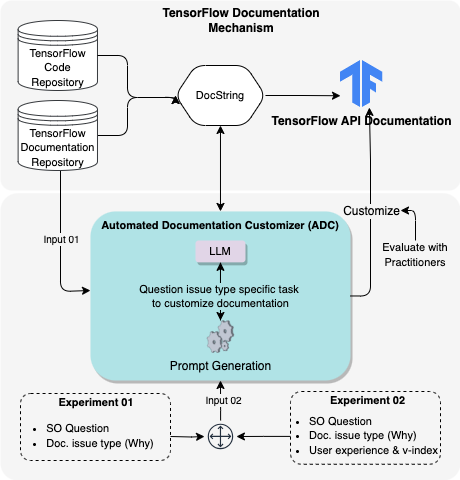

In [7]:
question_queries = pd.read_csv(os.path.join(s.DATA_PATH, "DocQues_NoAns_Issues_v3_2020_2023.csv"))
question_queries.head()

,QuestionId,Title,Body,QuestionsAPI,CurrentAPI,CreationDate,UserId,UserReputation,QuestionURL,IssueType
0,76447508,How to retrain a model that was saved using th...,<p>I am building a Neural Machine Translator f...,tf.saved_model.load,tf.saved_model.load,2023-04-17 23:39:34,16851318,41,https://stackoverflow.com/questions/76447508,Inadequate Examples
1,76396532,"Ragged tensors in dataset, tensorflow, how do ...","<p>I have</p>\n<pre><code>def call (self, inpu...",tf.data.Dataset,tf.data.Dataset,2023-04-12 14:26:12,13154958,1,https://stackoverflow.com/questions/76396532,Documentation Replicability
2,76391276,Custom gradient for broadcasting operation,<p>I have an operation for which I want to def...,tf.custom_gradient,tf.custom_gradient,2023-04-05 13:00:20,1782792,58906,https://stackoverflow.com/questions/76391276,Documentation Ambiguity
3,76380927,Tensorflow decode image,<p>I am a beginner in tensorflow and I am trai...,tf.io.decode_image,tf.io.decode_image,2023-03-05 8:02:03,15460221,11,https://stackoverflow.com/questions/76380927,Requesting (Additional) Documentation/Examples
4,76244268,Tensorflow: Build new model from input and mid...,<p>I'm trying to build <code>new_model</code> ...,tf.keras.applications.efficientnet_v2,tf.keras.applications.efficientnet_v2,2023-03-04 23:59:16,2103321,75,https://stackoverflow.com/questions/76244268,Inadequate Examples


In [9]:
def select_rows(group):
    return group.head(5)

result_df = question_queries.groupby('IssueType').apply(select_rows).reset_index(drop=True)
result_df

/var/folders/x7/c7r5kc051js_fytcq8jbvt040000gp/T/ipykernel_73229/3603017155.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = question_queries.groupby('IssueType').apply(select_rows).reset_index(drop=True)


,QuestionId,Title,Body,QuestionsAPI,CurrentAPI,CreationDate,UserId,UserReputation,QuestionURL,IssueType
0,76391276,Custom gradient for broadcasting operation,<p>I have an operation for which I want to def...,tf.custom_gradient,tf.custom_gradient,2023-04-05 13:00:20,1782792,58906,https://stackoverflow.com/questions/76391276,Documentation Ambiguity
1,76153107,Difference between tf.Module and tf.keras.Model,<p>I know both <code>tf.Module</code> and <cod...,tf.Module,tf.Module,2023-02-16 21:44:50,21760922,33,https://stackoverflow.com/questions/76153107,Documentation Ambiguity
2,75996642,Is there a good equivalent of pandas' `apply` ...,<p><strong>BACKGROUND</strong></p>\n<p>The use...,tf.py_function,tf.py_function,2022-11-14 15:44:35,5640161,791,https://stackoverflow.com/questions/75996642,Documentation Ambiguity
3,74434308,Setting only global level seed gives same outp...,<p>I am testing out the <code>tf.random.set_se...,tf.random.set_seed,tf.random.set_seed,2021-06-28 11:48:57,7422352,5021,https://stackoverflow.com/questions/74434308,Documentation Ambiguity
4,71619495,Image normalization by tf.image.convert_image_...,<p>According to documentation <code>tf.image.c...,tf.image.convert_image_dtype,tf.image.convert_image_dtype,2020-12-28 17:31:25,5094589,915,https://stackoverflow.com/questions/71619495,Documentation Ambiguity
5,73794766,what is the meaning of axis=-1 in tf.keras.lay...,<p>I'm trying to learn deep learning using ker...,tf.keras.layers.Normalization,tf.keras.layers.Normalization,2021-04-22 10:07:35,19986715,1,https://stackoverflow.com/questions/73794766,Documentation Completeness
6,76396532,"Ragged tensors in dataset, tensorflow, how do ...","<p>I have</p>\n<pre><code>def call (self, inpu...",tf.data.Dataset,tf.data.Dataset,2023-04-12 14:26:12,13154958,1,https://stackoverflow.com/questions/76396532,Documentation Replicability
7,75640862,tf.py_function is only for Eager Mode?,<p>Is <code>tf.py_function</code> only for Eag...,tf.py_function,tf.py_function,2022-06-27 12:56:46,4281353,20088,https://stackoverflow.com/questions/75640862,Documentation Replicability
8,75639137,TF1 to TF2 migration,<p>Hello I am new to tensorflow and I am worki...,tf.compat.v1.placeholder,tf.compat.v1.placeholder,2022-05-21 11:25:40,15822972,101,https://stackoverflow.com/questions/75639137,Documentation Replicability
9,75478235,tf.image.ssim() not accepting 'return_index_ma...,<p>The documentation for Tensorflow's <a href=...,tf.image.ssim,tf.image.ssim,2022-02-28 8:05:44,20324823,1,https://stackoverflow.com/questions/75478235,Documentation Replicability


**Load the vector database**

In [9]:
so_vector_db = Chroma(persist_directory=os.path.join(s.VECTORDB_PATH,"dataframe"), embedding_function=embedding_function)
# tf_vector_db = Chroma(persist_directory=os.path.join(s.VECTORDB_PATH,"markdown"), embedding_function=embedding_function)
yt_vector_db = Chroma(persist_directory=os.path.join(s.VECTORDB_PATH,"transcripts"), embedding_function=embedding_function)


<img src="/Users/sharukat/Documents/ResearchYU/Code/doc-customizer-llm/doc_customizer_llm/assets/RAG_Methodology.png" />

In [ ]:
# 'context', 'title','body', 'issue_type','definition', 'documentation', 'task'
for index, row in result_df.iterrows():
    try:
        so_with_score = so_vector_db.similarity_search_with_relevance_scores(row['Body'], k=3)
        yt_with_score = yt_vector_db.similarity_search_with_relevance_scores(row['Body'], k=3)

        docs = []
        video_urls = []
        # Obtain semantic similarity with the score with respect to the query (SO question)
        for doc, score in so_with_score:
            if score > 0.6:
                docs.append(doc.page_content)

        # Execute langchain agent to call Tavily search API using question title as the query
        res = agent_executor.invoke({"input": row['Title']})
        docs.append(res["output"])
        
        for script, score in yt_with_score:
            if score > 0.6:
                video_urls.append(doc.page_content)

        issue_type = row['IssueType']
        definition, task = hf.prompt_task(issue_type)
        documentation = hf.read_markdown_file(row['CurrentAPI'])

        prompts = [
            {
                "context" : '\n'.join(docs),
                "title" : row['Title'],
                "body" : row['Body'],
                "issue_type" : issue_type,
                "definition" : definition,
                "api_name":row['CurrentAPI'],
                "documentation": documentation,
                "task": task,
            },
        ]

        synopsis_chain.apply(prompts)
        mlflow_callback.flush_tracker(synopsis_chain)
    except:
        pass